# **Tutorial 5: Radiative Equilibrium**


**Week 1, Day 5, Climate Modeling**

**Content creators:** Jenna Pearson

**Content reviewers:** Yunlong Xu, Will Gregory, Peter Ohue, Derick Temfack, Zahra Khodakaramimaghsoud, Peizhen Yang, Younkap Nina Duplex, Ohad Zivan, Chi Zhang

**Content editors:** Brodie Pearson, Abigail Bodner, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS



# **Tutorial Objectives**

In this tutorial students will run a one-dimensional radiative equilibrium model that predicts the global mean atmospheric temperature as a function of height. Much of the code shown here was taken from [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook/home.html) by Brian Rose. Students are encouraged to visit this website for more tutorials and background on these models.

By the end of this tutorial students will be able to:
* Implement a 1-D model that predicts atmospheric temperature as a function of height using the python package `climlab`.
* Understand how this model builds off of the energy balance models developed in the previous tutorials.

# Setup

In [1]:
# google colab installs
# # note the conda install takes quite a while, but conda is REQUIRED to properly download the dependencies (that are not just python packages)
# !pip install condacolab &> /dev/null           # need to use conda installation of climlab, pip won't work. condacolab is a workaround
# import condacolab
# condacolab.install()
# !mamba install -c anaconda cftime xarray numpy &> /dev/null    # for decoding time variables when opening datasets
# !mamba install -c conda-forge metpy climlab &> /dev/null

In [2]:
# imports 
import xarray as xr                     # used to manipulate data and open datasets
import numpy as np                      # used for algebra/arrays
import urllib.request                   # used to download data from the internet
import climlab                          # one of the models we are using
import matplotlib.pyplot as plt         # used for plotting
import metpy                            # used to make Skew T Plots of temperature and pressure
from metpy.plots import SkewT           # plotting function used widely in climate science
import pooch
import os


C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
C:\Users\ohadz\AppData\Roaming\Python\Python310\site-packages\climlab\convection\akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


In [ ]:
# @title Figure Settingsimport ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Radiative Equilibrium
#Tech team will add code to format and display the video

# Section 1: Setting up the Radiative Equilibrium Model Using Climlab



The energy balance model we used earlier today was *zero-dimensional*, yielding only the global mean surface temperature. We might ask, is it possible to construct a similar, *one-dimensional*, model for an *atmospheric column* to estimate the global mean temperature *profile* (i.e., including the height/$z$ dimension). Additionally, can we explicity include the effects of different gases in this model, rather than just parametrizing their collective effects through a single parameter $\tau$? **The answer is yes, we can!**

This model is too complex to construct from scratch, as we did in the previous tutorials. Instead, we will use a model already available within the python package [climlab](https://climlab.readthedocs.io/en/latest/intro.html). 
 
**Radiative equilibrium models** consider different layers of the atmosphere. Each of these layers absorbs and emits radiation depending on its constituent gases, allowing the model to calculate the radiation budget fo each layer as radiative energy is transfered between atmospheric layers, the Earth's surface, and space. **Radiative equilibrium** is reached when each layer gain energy at the same rate as it loses energy. In this tutorial we will analyze the temperature profile of this new model once it has reached equilibrium.

To set up this model, we will need information about some of the mean properties of the atmosphere. We are going to download water vapor data from the Community Earth System Model, a global climate model that we will go into detail on in the next tutorial, to use a variable called [specific humidity](https://glossary.ametsoc.org/wiki/Specific_humidity). **Specific humidity** is the mass of water vapor per mass of a unit block of air. This is useful because water vapor, an important greenhouse gas.

There are two ways to do this, manually downloading data and accessing from drive, or accessing via the internet.


In [4]:
# data source : http://thredds.atmos.albany.edu:8080/thredds/fileServer/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
# filename "cpl_1850_f19-Q-gw-only.cam.h0.nc"

url_sq = "https://osf.io/c6q4j/download/"
ds = xr.open_dataset(pooch.retrieve(url_sq,known_hash=None)) # ds = dataset
ds

<xarray.Dataset>
Dimensions:  (time: 240, lev: 26, lat: 96, lon: 144)
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    Q        (time, lev, lat, lon) float32 ...
    gw       (lat) float64 ...
Attributes: (12/13)
    Conventions:               CF-1.0
    source:                    CAM
    case:                      cpl_1850_f19
    title:                     UNSET
    logname:                   br546577
    host:                      snow-30.rit.alba
    ...                        ...
    revision_Id:               $Id$
    initial_file:              b40.1850.track1.2deg.003.cam.i.0501-01-01-0000...
    topography_file:           /data/rose_scr/cesm_inputdata/atm/cam/topo/USG...
    history:                   Tue Feb 26 17:17:15 2019: ncrcat atm/hist/cpl_...
    NCO:                       4.6.8
    nco_openmp_thread_number:  1

In [5]:
# the specific humidity is stored in a variable called Q
ds.Q

<xarray.DataArray 'Q' (time: 240, lev: 26, lat: 96, lon: 144)>
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

however, we want an annual average profile:

In [6]:
# take global, annual average using a weighting (ds.gw) that is calculated based on the model grid - and is similar, but not identical, to a cosine(latitude) weighting

weight_factor = ds.gw / ds.gw.mean(dim='lat')
Qglobal = (ds.Q * weight_factor).mean(dim=('lat','lon','time'))
# print specific humidity profile
Qglobal

<xarray.DataArray (lev: 26)>
array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

Now that we have a global mean water vapor profile, we can define a model that has the same vertical levels as this water vapor data.

In [7]:
# use 'lev=Qglobal.lev' to create an identical vertical grid to water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

To model the absorption and emission of different gases within each atmospheric layer, we use the **[Rapid Radiative Transfer Model](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html)**, which is contained within the `RRTMG` module. We must first initialize our model using the water vapor .

In [8]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

Let's explore this initial state. Here `Ts` is the initial global mean surface temperature, and `Tatm` is the initial global mean air temperature profile.

In [9]:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

One of the perks of using this model is it's ability to incorporate the radiative effects of individual greenhouse gases in different parts of the radiation spectrum, rather than using a bulk reduction in transmission of outgoing longwave radiation (as in our previous models).

Let's display 'absorber_vmr', which contains the **volume mixing ratio**'s of each gas used in the radiative transfer model (these are pre-defined; and do not include the water vapor we used as a model input above). The volume mixing ratio describes the fraction of molecules in the air that are a given gas. For example, $21\%$ of air is oxygen and so it's volumn mixing ratio is 0.21.

In [10]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

To look at carbon dioxide (`CO2`) in a more familiar unit, parts per million (by volume), we can convert and print the new value.

In [11]:
radmodel.absorber_vmr['CO2'] * 1E6

348.0

We can also look at all the available diagnostics of our model:

In [12]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset>
Dimensions:           (depth: 1, depth_bounds: 2, lev: 26, lev_bounds: 27)
Coordinates:
  * depth             (depth) float64 1.25
  * depth_bounds      (depth_bounds) float64 0.0 2.5
  * lev               (lev) float64 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * lev_bounds        (lev_bounds) float64 0.0 5.467 10.68 ... 950.1 981.6 1e+03
Data variables: (12/26)
    OLR               (depth) float64 0.0
    OLRclr            (depth) float64 0.0
    OLRcld            (depth) float64 0.0
    TdotLW            (lev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TdotLW_clr        (lev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LW_sfc            (depth) float64 0.0
    ...                ...
    SW_flux_up        (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_down      (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_net       (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_up_clr    (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_down_clr  (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_net_clr   (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

For example to look at OLR,

In [13]:
radmodel.OLR

Field([0.])

Note. the OLR is currently 0 as we have not ran the model forward in time, so it has not calculated any radiation components.

## Questions 1

1.  Why do you think all gases, except ozone and water vapor, are represented by single values in the model?

In [14]:
# to_remove explanation

"""
1. The gases aside from ozone and water vapor are all assumed to be well mixed in the atmosphere. This means that we assume they have the same concentration anywhere you measure. However, we know from observations that ozone and water vapor are not well mixed in the atmosphere.
"""

'\n1. The gases aside from ozone and water vapor are all assumed to be well mixed in the atmosphere. This means that we assume they have the same concentration anywhere you measure. However, we know from observations that ozone and water vapor are not well mixed in the atmosphere.\n'

## Coding Exercises 1

1.  On the same graph, plot the annual mean specific humidity profile and ozone profiles.

In [15]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("On the same graph, plot the annual mean specific humidty profile and ozone profiles.")
#################################################

#  multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
plt.plot(..., ...,label = ...)
# multiply by 1E6 to get units of ppmv = parts per million by volume
plt.plot(..., ...,label = ...)

# pressure decreases logarithmically with heigh in the atmosphere
# invert the axis so the largest value of pressure is lowest
plt.gca().invert_yaxis()
# set y axis to a log scale
plt.yscale('log')

plt.ylabel('Pressure (hPa)')
plt.xlabel('Specific humidity (g/kg)')

# turn on the grid lines
plt.grid()

NotImplementedError: On the same graph, plot the annual mean specific humidty profile and ozone profiles.

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

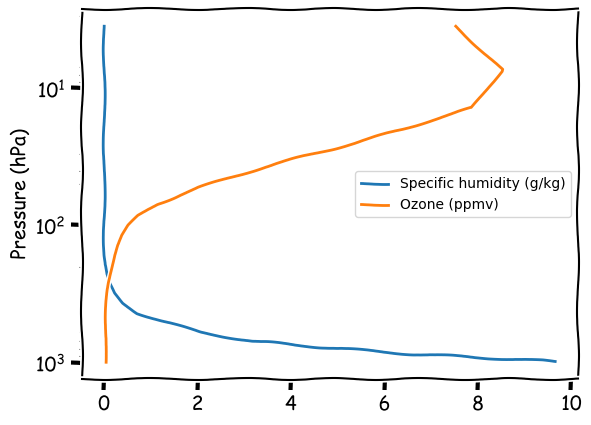

In [16]:
# to_remove solution

with plt.xkcd():
  # multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
  plt.plot(Qglobal*1000., Qglobal.lev, label = 'Specific humidity (g/kg)')
  # multiply by 1E6 to get units of ppmv = parts per million by volume
  plt.plot(radmodel.absorber_vmr['O3']*1E6,radmodel.lev, label = 'Ozone (ppmv)')

# pressure decreases logarithmically with height in the atmosphere
# invert the axis so the largest value of pressure is lowest
plt.gca().invert_yaxis()
# set y axis to a log scale
plt.yscale('log')

plt.ylabel('Pressure (hPa)')

# turn on the grid lines
plt.grid()

# turn on legend
plt.legend()

# Section 2: Getting Data to Compare to the Model

Before we run our model forward, we will download a reanalysis product from NCEP to get a sense of what the real global mean atmospheric temperature profile looks like. We will compare this profile to our model runs later.

In [17]:
# data source: https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.1981-2010.ltm.nc
# ohad comment: the text above should contain info about why this dataset datetime is broken. 
# as it's a model year from I undestand

url_ncep_air = "https://osf.io/w6cd5/download/"
ncep_air = xr.open_dataset(pooch.retrieve(url_ncep_air,known_hash=None)) # ds = dataset

# this is the long term monthly means
ncep_air.air

C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime 

<xarray.DataArray 'air' (time: 12, level: 17, lat: 73, lon: 144)>
[2144448 values with dtype=float32]
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    long_name:     Monthly Long Term Mean of Air temperature
    units:         degC
    precision:     2
    var_desc:      Air Temperature
    level_desc:    Pressure Levels
    statistic:     Long Term Mean
    parent_stat:   Mean
    valid_range:   [-200.  300.]
    actual_range:  [-89.722336  41.616005]
    dataset:       NCEP Reanalysis Derived Products

In [20]:
ncep_air_test = xr.open_dataset(dd'air.mon.1981-2010.ltm.nc') # ds = dataset
ncep_air_test

C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\ProgramData\Anaconda3\envs\climatematch\lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime 

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [18]:
# need to take the average over space and time
# the grid cells are not the same size moving towards the poles, so we weight by the cosine of latitude to compensate for this
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')

Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
Tglobal

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

Below we will define two helper funcitons to visualize the profiles output from our model with a *SkewT* plot. This is common way to plot atmospheric temperature in climate science, and the `metpy` package has a built in function to make this easier.



In [19]:
# to setup the skewT and plot observations
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    # skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

In [20]:
# to add a model derived profile to the skewT figure
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o',
              markersize=8, color=line.get_color())
    skew.ax.legend()

In [22]:
skew = make_skewT()
# ohad comment: something with the inline is making the plot not appear for me. same thing for all make_skewT calls
# %config InlineBackend.figure_format = 'retina'

SkewT (also known as SkewT-logP) plots are generally used for much [more complex reasons](https://www.weather.gov/source/zhu/ZHU_Training_Page/convective_parameters/skewt/skewtinfo.html) than we will use here. However, one of the benefits of this plot that we will utilize is the fact that pressure decreases approximately logarithmically with height. Thus, with a *logP* axis, we are showing information that is roughly linear in height, making the plots more intuitive. 

# Section 3: Running the Radiative Equilibrium Model Forward in Time

We can run this model over many time steps, just like the simple greenhouse model, but now we can examine the behavior of the temperature profile rather than just the surface temperature. 

There is no need to write out a function to step our model forward - `climlab` already has this feature. We will use this function to run our model to equilibrium (i.e., until OLR is balanced by ASR).

In [23]:
# take a single step forward to the diagnostics are updated and there is some energy imbalance
radmodel.step_forward() 

# run the model to equilibrium (the difference between ASR and OLR is a very small number)
while np.abs(radmodel.ASR - radmodel.OLR) > 0.001:
    radmodel.step_forward()

In [24]:
#  check the energy budget to make sure we are really at equilibrium
radmodel.ASR - radmodel.OLR

Field([0.0009879])

Now let's can compare this to observations.

In [25]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure Radiative Equilibrium', fontsize=18);

## Questions 3

1. The profile from our model does not match observations well. Can you think of one component we might be missing?
2. What effect do you think the individual gases play in determining this profile and why?

In [26]:
# to_remove explanation

"""
1. One thing we are currently lacking is physiccal processes (aside from radiation) in our model.
2. This is a hard question to answer! Luckily we can remove gases one at a time from our model to study their individual impact. Any ideas you have here can be tested with this model!
"""

'\n1. One thing we are currently lacking is physiccal processes (aside from radiation) in our model.\n2. This is a hard question to answer! Luckily we can remove gases one at a time from our model to study their individual impact. Any ideas you have here can be tested with this model!\n'

## Coding Exercises 3

1. Create a second model called 'Radiation (no H20)' that lacks water vapor. Then re-create the plot above, but add on this extra profile without water vapor.

In [27]:
#################################################
# Students: Fill in missing code (...) and comment or remove the next line
raise NotImplementedError("Student exercise: Create a second model called 'Radiation (no H20)' that lacks water vapor. Then re-create the plot above, but add on this extra profile without water vapor.")
#################################################

# make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
# change the name of our new model
radmodel_noH2O.name = ...

# set the water vapor profile to all zeros
radmodel_noH2O.specific_humidity *= 0.

# run the model to equilibrium
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    ...

# create skewT plot
skew = make_skewT()

# add profiles for both models to plot
for model in [...]:
    ...

NotImplementedError: Student exercise: Create a second model called 'Radiation (no H20)' that lacks water vapor. Then re-create the plot above, but add on this extra profile without water vapor.

In [29]:
# to_remove solution

# make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
# change the name of our new model
radmodel_noH2O.name = 'Radiation (no H2O)'

# set the water vapor profile to all zeros
radmodel_noH2O.specific_humidity *= 0.

# run the model to equilibrium
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

# create skewT plot
with plt.xkcd():z
  skew = make_skewT()

# add profiles for both models to plot
for model in [radmodel, radmodel_noH2O]:
    with plt.xkcd():
      add_profile(skew, model)